In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import autograd
import pandas as pd
np.random.seed(0)

In [3]:

def grad_Hamiltonian(t,r):
        q, p = r 
        tfq= tf.Variable([q])
        tfp= tf.Variable([p])
        with tf.GradientTape() as g:
            g.watch([tfp,tfq])
            H= tfq**2+ tfp**2
            dHdq,dHdp = g.gradient(H, [tfq,tfp])    # pdot=-dH_dq,qdot=dH_dp
        S = np.concatenate([dHdp, -dHdq], axis=-1)
        return S
        

# trajectory

def trajectory(t,y0):
   
    noise_std=0.1
    sol = integrate.solve_ivp(fun=grad_Hamiltonian,t_span=t,y0=y0)
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    # add noise
    q_new += np.random.randn(*q_new.shape)*noise_std
    p_new += np.random.randn(*p_new.shape)*noise_std
    return q_new,p_new,dq,dp

In [4]:
def get_dataset(seed=0, samples=50, test_split=0.2):    # inja 50ta nemune random az file data bardashte be surste zoje moratab p&q va dp&dq neveshte va 20 darsad oona ro dade test ghara dade
    data = {'meta': locals()}
    t=[0,10]
    y0=np.asarray([1.0,0.0])
    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        q, p, dq, dp= trajectory(t,y0)
        xs.append( np.stack( [q, p]).T )
        dxs.append( np.stack( [dq, dp]).T )
        
    data['q&p'] = np.concatenate(xs)
    data['dq&dp'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['q&p']) * test_split)
    split_data = {}
    for k in ['q&p', 'dq&dp']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [55]:
data = get_dataset()
x_train = tf.constant(data['q&p'], dtype=tf.float32)
x_test = tf.constant( data['test_q&p'], dtype=tf.float32)
y_train = tf.constant(data['dq&dp'])
y_test = tf.constant(data['test_dq&dp'])

In [77]:
myModel=keras.models.Sequential()
myModel.add(keras.layers.Flatten(input_shape=[2]))
#myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(200, activation="tanh"))
myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(200, activation="tanh"))
myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(2))#, activation="sigmoid"))
myModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               600       
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 402       
Total params: 41,202
Trainable params: 41,202
Non-trainable params: 0
__________________________________________________

In [78]:
# def loss(t,p):
#     return(t-p)**2

In [80]:
myModel.compile(loss=tf.keras.losses.MeanAbsoluteError(),#loss
                optimizer=keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])

trainedModel=myModel.fit(x_train,y_train, epochs=20
                        ,validation_split=(0.2))

Epoch 1/20
7/7 [==============================] - 0s 26ms/step - loss: 0.1967 - accuracy: 0.9750 - val_loss: 0.1775 - val_accuracy: 0.9800
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2049 - accuracy: 0.9700 - val_loss: 0.1663 - val_accuracy: 0.9800
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.1983 - accuracy: 0.9450 - val_loss: 0.1649 - val_accuracy: 0.9800
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.1904 - accuracy: 0.9750 - val_loss: 0.1696 - val_accuracy: 0.9800
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.1898 - accuracy: 0.9700 - val_loss: 0.1638 - val_accuracy: 0.9800
Epoch 6/20
7/7 [==============================] - 0s 8ms/step - loss: 0.1901 - accuracy: 0.9700 - val_loss: 0.1600 - val_accuracy: 0.9800
Epoch 7/20
7/7 [==============================] - 0s 6ms/step - loss: 0.1870 - accuracy: 0.9700 - val_loss: 0.1610 - val_accuracy: 0.9600
Epoch 8/20
7/7 [=================

<AxesSubplot:>

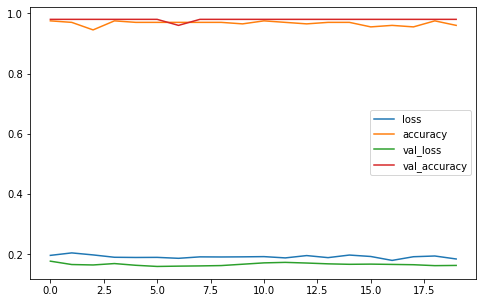

In [81]:
pd.DataFrame(trainedModel.history).plot(figsize=(8, 5))

In [82]:
myModel.evaluate(x_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.1511 - accuracy: 0.9690


[0.15113842487335205, 0.968999981880188]

In [83]:
def pred_pdot_qdot(t,r):
    q,p = r 
    new_init_val= np.array([[p,q]])
    y=myModel.predict(new_init_val)[0]
    return(y[1],y[0])

In [84]:
def Data(t,y0):
    noise_std=0.1
    sol = integrate.solve_ivp(fun=pred_pdot_qdot,t_span=t,y0=y0)
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    # add noise
    q_new += np.random.randn(*q_new.shape)*noise_std
    p_new += np.random.randn(*p_new.shape)*noise_std
    return q_new,p_new,dq,dp

In [85]:
t=[0,100]
init_val=np.asarray([1.0,0.0])
pred_p,pred_q,pred_pdot,pred_qdot=Data(t,init_val)

In [86]:
# def HNN():

Text(0, 0.5, 'qdot')

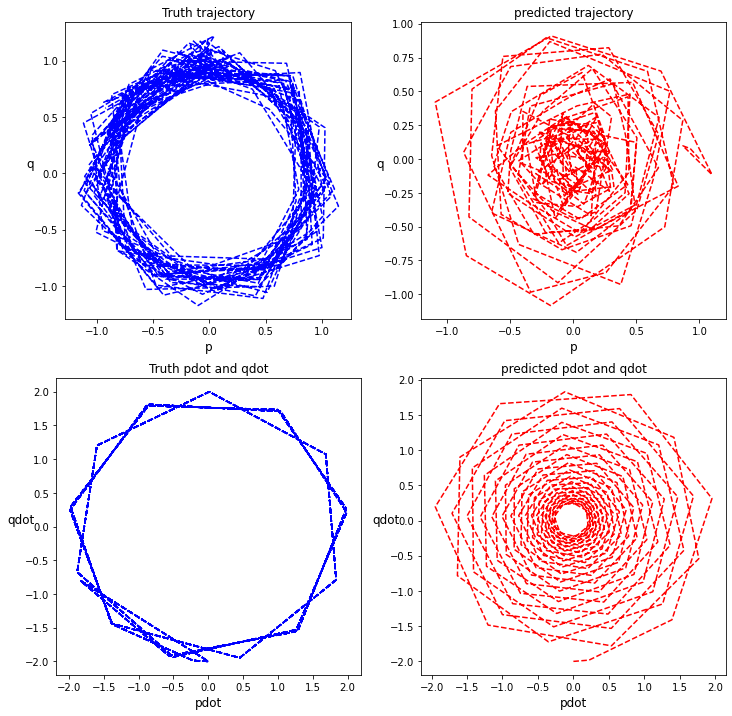

In [87]:
x,y=np.transpose(x_train)
xx,yy=np.transpose(y_train)
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(y,x,'b--')
plt.axis('scaled')
plt.title('Truth trajectory')
plt.xlabel('p', fontsize=12)
plt.ylabel('q',rotation=0, fontsize=12)

plt.subplot(222)
plt.plot(pred_p,pred_q,'r--')
#plt.axis('scaled')
plt.title('predicted trajectory')
plt.xlabel('p', fontsize=12)
plt.ylabel('q',rotation=0, fontsize=12)


plt.subplot(224)
plt.plot(pred_pdot[0],pred_qdot[0],'r--')
#plt.axis('scaled')
plt.title('predicted pdot and qdot')
plt.xlabel('pdot', fontsize=12)
plt.ylabel('qdot',rotation=0, fontsize=12)

plt.subplot(223)
plt.plot(xx,yy,'b--')
#plt.axis('scaled')
plt.title('Truth pdot and qdot')
plt.xlabel('pdot', fontsize=12)
plt.ylabel('qdot',rotation=0, fontsize=12)

In [88]:
Ht=x**2+y**2
Hp=pred_q**2+pred_p**2

In [89]:
meanE=np.mean(Ht)*np.ones(len(x))
pmeanE=np.mean(Hp)*np.ones(len(pred_p))

In [68]:
pmeanE[0]

0.8220943650989392

Text(0, 0.5, '$H$')

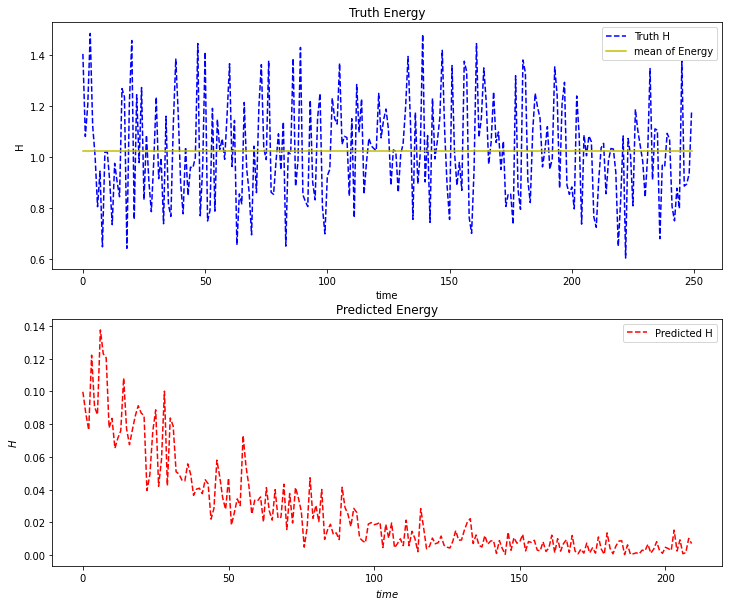

In [90]:
plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(Ht,'b--')
plt.plot(meanE,'y')
plt.title('Truth Energy')
plt.xlabel('time')
plt.ylabel('H')
plt.legend(['Truth H','mean of Energy'])

plt.subplot(212)
plt.plot(Hp/10,'r--')
#plt.plot(pmeanE,'y')
plt.title('Predicted Energy')
plt.legend(['Predicted H'])
plt.xlabel('$time$')
plt.ylabel('$H$')


